<h1><center>Démonstration du module PyPortfolioOpt sur le portefeuille du club </center></h1>
<h2><center>LSM Investment Club - Team Quant </center></h2>
<h3><center>Adrien </center></h3>

Pourquoi utiliser ce module ? Je veux comparer les estimations empiriques de la team portfolio sur l'attribution des poids à chaque action et essayer d'optimiser le portefeuille de plusieurs manières et de comparer :
- Minimiser le risque sous condition d'un maximum de gain
- Maximiser le gain sous condition  d'un minimum de risque
- Maximiser le sharpe ratio sous conditions
 
Ce genre de problème est facilement reformulé sous un problème d'optimisation convexe et comme nous avons vu en opti 1, c'est une classe de problèmes bien plus régulière et avec certaines propriétés concernant l'existence de solution etc.

https://pyportfolioopt.readthedocs.io/en/latest/index.html
Ce module ne sort pas de nulle part, a plus de 4500 étoiles sur Github, son créateur travaille en tant que trader chez D.E Shaw (https://www.linkedin.com/in/robert-a-martin/), seule bibliothèque reconnue sur Python pour ce genre de modélisation/calculs.

Les informations sur le portefeuille ne sont peut-être pas actualisées, mais au moins elles reflètent une part historiquement importante des actifs du club, donc l'analyse reste pertinente, 

voir https://docs.google.com/spreadsheets/d/1ADK8enoEoA7vzp9y66nytM0gFdPer38v/edit?gid=448484424#gid=448484424

In [1]:
import yfinance as yf
import numpy as np
tickers = [
    "AED.BR",       # Aedifica NV
    "AAPL",         # Apple Inc
    "BFIT.AS",      # Basic Fit NV
    "BX",           # Blackstone Inc
    "ENPH",         # Enphase Energy Inc
    "EVO.ST",       # Evolution AB (publ)
    "HFG.DE",       # Hellofresh SE
    "INRG.MI",      # iShares Global Clean Energy UCITS ETF USD (Dist)
    "HEAL.AS",      # iShares Healthcare Innovation UCITS ETF USD A
    "IESE.AS",      # iShares MSCI Europe SRI UCITS ETF EUR (Acc)
    "SGLN.L",       # iShares Physical Gold
    "MC.PA",        # LVMH Moet Hennessy Louis Vuitton SE
    "MA",           # Mastercard Inc
    "MRK",          # Merck & Co Inc
    "MSFT",         # Microsoft Corp
    "NESN.SW",      # Nestle SA
    "OGN",          # Organon & Co
    "SGM.F",        # STMicroelectronics NV
    "TEP.PA",       # Teleperformance SE
    "TCEHY",        # Tencent Holdings ADR
    "UMI.BR",       # Umicore SA
    "WLN.PA"        # Worldline SA
]

raw_weights = np.array([
    0.0348, 0.1431, 0.0172, 0.0347, 0.0173,
    0.0160, 0.0042, 0.0182, 0.0218, 0.0528,
    0.0933, 0.0838, 0.0623, 0.0554, 0.1395,
    0.0199, 0.0007, 0.0173, 0.0214, 0.0376,
    0.0070, 0.0031
]) # Issu du fichier Google Docs, en excluant les liquidités


actual_weights = raw_weights / np.sum(raw_weights)

start_date = "2022-10-25"
end_date = "2024-10-25"

df = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()
df.index = df.index.strftime('%Y-%m-%d') # Omettre l'heure sur la date

df.head


[*********************100%***********************]  22 of 22 completed


<bound method NDFrame.head of Ticker            AAPL     AED.BR    BFIT.AS          BX        ENPH  \
Date                                                                   
2022-10-25  152.339996  78.353767  30.620001   91.550003  265.589996   
2022-10-26  149.350006  75.569382  31.080000   92.739998  291.869995   
2022-10-27  144.800003  78.158371  30.559999   93.449997  306.079987   
2022-10-28  155.740005  76.155563  24.760000   93.180000  305.250000   
2022-10-31  153.339996  75.422829  25.500000   91.139999  307.000000   
...                ...        ...        ...         ...         ...   
2024-10-18  235.000000  63.000000  25.080000  172.360001   91.639999   
2024-10-21  236.479996  61.849998  23.980000  170.770004   90.419998   
2024-10-22  235.860001  60.950001  23.879999  168.500000   92.230003   
2024-10-23  230.759995  60.750000  23.860001  166.919998   78.470001   
2024-10-24  230.570007  60.700001  23.200001  169.660004   81.099998   

Ticker           EVO.ST  HEAL.AS 

In [2]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(df) # Estimation des expected return 
S = CovarianceShrinkage(df).ledoit_wolf() # Estimation de la matrice de covariance, Ledoit-Wolf est utile pour les matrices de grandes dimensions

---

## Modèle classique du portefeuille de Markowitz (1952) / Mean-variance optimization 

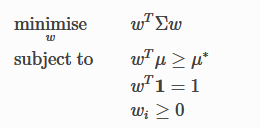

L'image ci-dessus nous montre le problème que nous essayons de résoudre, il faut minimiser le risque du portefeuille, donc la fonction objectif, en fonction du vecteur de poids $w$ attribué à chaque action tel que :
- Le retour de notre portefeuille soit supérieur à une valeur minimale $\mu^*$, notre objectif de return.

(et deux triviales)
- La somme du vecteur $w$ soit 1.
- Les poids soient non négatifs. 

Le paquet résout ce problème pour nous par les commandes suivantes : 

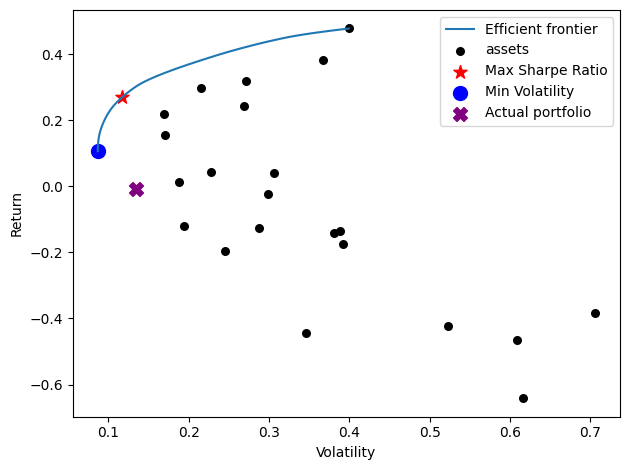

In [3]:
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting # Ici j'ai eu un problème, la police de plotting n'était plus dispo, j'ai donc dû supprimer une ligne du code de base
ef = EfficientFrontier(mu, S, weight_bounds = (0,1)) # Ici j'ai dû aller chercher une licence d'essai pour le solver "Mosek"

# On peut aussi utiliser max_quadratic_utility, efficient_risk (max return pour un risque donné), efficient_return(min volatilité pour un return donné), et on peut en faire des personnalisés aussi mais compliqué.

ef.max_sharpe() # risk_free_rate=0.02, paramètre de base
max_sharpe_weights = ef.clean_weights() # Nettoie les poids pour avoir des chiffres plus clairs, juste esthétique.
max_sharpe_return, max_sharpe_risk, max_sharpe_ratio = ef.portfolio_performance()

ef = EfficientFrontier(mu, S, weight_bounds = (0,1)) # Il faut redéfinir l'EfficientFrontier à chaque manipulation (résolution) dessus.
ef.min_volatility()
min_volatility_weights = ef.clean_weights()
min_vol_return, min_vol_risk, _ = ef.portfolio_performance()

# Retour et volatilité du portfolio actuel
actual_return = np.dot(actual_weights, mu)  # Expected portfolio return
actual_volatility = np.sqrt(np.dot(actual_weights.T, np.dot(S, actual_weights)))

ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))  
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax = ax, show_assets = True)
ax.scatter(max_sharpe_risk, max_sharpe_return, marker="*", color="r", s=100, label="Max Sharpe Ratio")
ax.scatter(min_vol_risk, min_vol_return, marker="o", color="b", s=100, label="Min Volatility")
ax.scatter(actual_volatility, actual_return, marker="X", color="purple", s=100, label="Actual portfolio")
plt.legend()
plt.show()

In [4]:
min_volatility_weights

OrderedDict([('AAPL', 0.03046),
             ('AED.BR', 0.01474),
             ('BFIT.AS', 0.0),
             ('BX', 0.0),
             ('ENPH', 0.0),
             ('EVO.ST', 0.01318),
             ('HEAL.AS', 0.12014),
             ('HFG.DE', 0.0),
             ('IESE.AS', 0.12818),
             ('INRG.MI', 0.02268),
             ('MA', 0.06543),
             ('MC.PA', 0.0),
             ('MRK', 0.12711),
             ('MSFT', 0.04278),
             ('NESN.SW', 0.13973),
             ('OGN', 0.0),
             ('SGLN.L', 0.28057),
             ('SGM.F', 0.0),
             ('TCEHY', 0.00633),
             ('TEP.PA', 0.00653),
             ('UMI.BR', 0.00213),
             ('WLN.PA', 0.0)])

In [5]:
max_sharpe_weights

OrderedDict([('AAPL', 0.01644),
             ('AED.BR', 0.0),
             ('BFIT.AS', 0.0),
             ('BX', 0.0345),
             ('ENPH', 0.0),
             ('EVO.ST', 0.0),
             ('HEAL.AS', 0.0),
             ('HFG.DE', 0.0),
             ('IESE.AS', 0.0986),
             ('INRG.MI', 0.0),
             ('MA', 0.20752),
             ('MC.PA', 0.0),
             ('MRK', 0.02199),
             ('MSFT', 0.11683),
             ('NESN.SW', 0.0),
             ('OGN', 0.0),
             ('SGLN.L', 0.39858),
             ('SGM.F', 0.0),
             ('TCEHY', 0.10553),
             ('TEP.PA', 0.0),
             ('UMI.BR', 0.0),
             ('WLN.PA', 0.0)])

---

Le fait que notre portefeuille actuel (en violet) ne soit pas sur la frontière optimale montre que selon nos données, nous pourrions avoir un retour plus élevé pour le même risque, un risque plus faible pour un retour plus élevé, et n'importe quelle moyenne des portefeuille sur la frontière, c'est donc un portefeuille sous-optimal ! La seule chose à ajuster étant la date de départ mais ce n'est pas parce que nous avons fait un retour positif sur une période donnée que nous ne devrions pas reconsidérer notre choix actuel de portefeuille.

Nous pourrions nous dire que beaucoup d'actions sont mises à 0, alors deux choses, la première est qu'il est possible d'introduire des contraintes, c'est-à-dire, je veux que mon CLUB mette x % en ETF, y % en actions, 
mais comment choisir ces %, il serait arbitraire, si un ETF performe mieux, pourquoi faudrait-il sanctionner notre portefeuille avec des actions juste car on a analysé une boîte pourrie ? Ensuite, il est possible selon le paquet d'introduire des conditions de "régularisation L2", grossièrement ça introduit une fonction objectif qui va pénaliser le fait d'avoir des actions proches de 0, pour pousser à la diversification. 

Bien sûr il y a des limitations, l'or (SGLN.L) a pris sur les 2 dernières années à cause de l'enchaînement COVID + UKRAINE qui a fait paniquer certains marchés, donc ce n'est peut-être aujourd'hui pas une bonne solution d'en mettre autant, c'est juste que selon nos données, remontant jusqu'à 2 ans, cela semble être une bonne idée. C'est fortement sujet à interprétation, nous pourrions introduire des contraintes en plus, ce modèle est très basique, pas de vraie notion de prédiction, malgré que ça puisse impressionner.

---

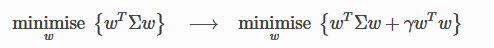

Exemple de régularisation L2, de préférence $\gamma \geq 1$ et peut être bien plus grand que 1 si on a plus de 20 tickers.

---

## Méthode semivariance

Voir https://www.hudsonbaycapital.com/documents/FG/hudsonbay/research/599440_paper.pdf, notamment page 24 pour la formulation précise en optimisation.

Point majeur : On utilise la semi variance qui ne capte que les données se trouvant en-dessous de la moyenne, car nous voulons avoir de la volatilité vers le haut pour augmenter notre gain.

Point négatif de la méthode : Beaucoup d'artifices sont utilisés par le solver pour rendre le problème faisable, sauf qu'il faut se tenir à des plus courtes périodes car il introduit un nombre de variables dépendant 
du nombre de jours dans le df sur les données financières. C'est moins stable car on ne peut pas calculer le Sharpe ratio donc on doit utiliser le Sortino ratio (l'idée est la même que le Sharpe), par contre comparer les deux n'aurait pas vraiment de sens.

c:\Users\porti\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


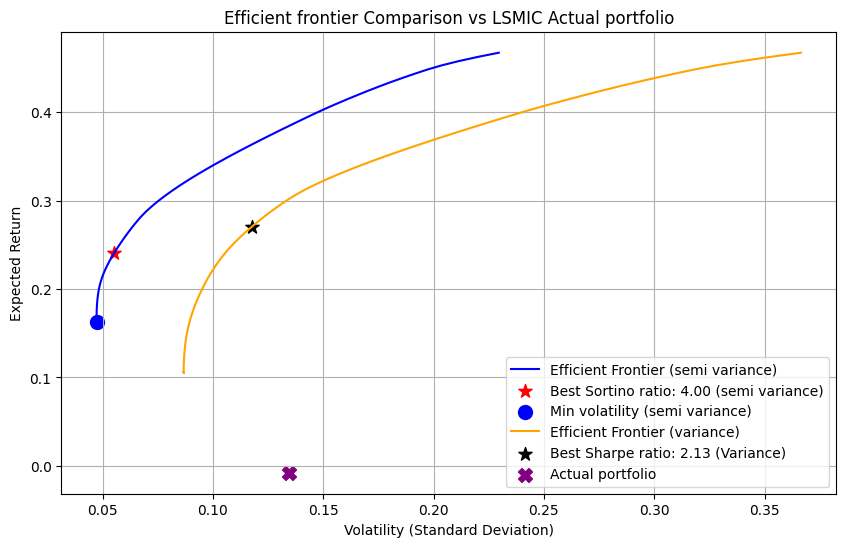

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns, EfficientFrontier, EfficientSemivariance

# Même code qu'avant sauf qu'on utilise la semi variance

mu = expected_returns.mean_historical_return(df)
historical_returns = expected_returns.returns_from_prices(df)
target_returns = np.linspace(0, mu.max()-0.01, 100)

es = EfficientSemivariance(mu, historical_returns, weight_bounds=(0, 1))  # Il faut redéfinir l'EffcientSemivariance à chaque manipulation (résolution) dessus.
risks_es = []
returns_es = []
max_sortino_es = -np.inf

for target_return in target_returns:
    es = EfficientSemivariance(mu, historical_returns, weight_bounds=(0, 1),solver='ECOS')
    es.efficient_return(target_return)
    portfolio_return,portfolio_risk,sortino_ratio = es.portfolio_performance()
    risks_es.append(portfolio_risk)
    returns_es.append(portfolio_return)
    if sortino_ratio > max_sortino_es:
        max_sortino_es = sortino_ratio
        best_sortino_return = portfolio_return
        best_sortino_risk = portfolio_risk

# Calcul de la frontière efficace traditionnelle
mu = expected_returns.mean_historical_return(df) # Estimation des expected return 
S = CovarianceShrinkage(df).ledoit_wolf() # Estimation de la matrice de covariance, Ledoit-Wolf est utile pour les matrices de grandes dimensions
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
risks_ef = []
returns_ef = []

for target_return in target_returns:
    ef.efficient_return(target_return)
    portfolio_return,portfolio_risk,_ = ef.portfolio_performance()
    risks_ef.append(portfolio_risk)
    returns_ef.append(portfolio_return)

# Tracé des deux frontières efficaces
plt.figure(figsize=(10, 6))
plt.plot(risks_es, returns_es, label="Efficient Frontier (semi variance)", color="blue")
plt.scatter(best_sortino_risk, best_sortino_return, marker="*", color="red", s=100, 
            label="Best Sortino ratio: {:.2f} (semi variance)".format(max_sortino_es))
es = EfficientSemivariance(mu, historical_returns, weight_bounds=(0, 1))
es.min_semivariance()
min_volatility_weights = es.clean_weights()
min_vol_return, min_vol_risk, _ = es.portfolio_performance()
plt.scatter(min_vol_risk, min_vol_return, marker="o", color="b", s=100, label="Min volatility (semi variance)")


plt.plot(risks_ef, returns_ef, label="Efficient Frontier (variance)", color="orange")
plt.scatter(max_sharpe_risk, max_sharpe_return, marker="*", color="black", s=100, label="Best Sharpe ratio: {:.2f} (Variance)".format(max_sharpe_ratio))

actual_return = np.dot(actual_weights, mu)  # Expected portfolio return
actual_volatility = np.sqrt(np.dot(actual_weights.T, np.dot(S, actual_weights)))
plt.scatter(actual_volatility, actual_return, marker="X", color="purple", s=100, label="Actual portfolio")



# Personnalisation du graphique
plt.title("Efficient frontier Comparison vs LSMIC Actual portfolio")
plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Expected Return")
plt.legend()
plt.grid()
plt.show()


Encore une fois, on veut que notre portefeuille n'est pas du tout optimal par rapport à ces deux types de mesure, encore une fois à considérer avec les problèmes de l'échelle temporelle et des données.

--- 

## Méthode sur l'expected shortfall

Sans rentrer dans les détails ici, on considère une autre optimisation du portefeuille qui correspond à minimiser l'expected shortfall, ce qui peut être assez intéressant pour le club qui vise du moyen terme. Il y a moyen d'approximer la résolution du problème en une optimisation linéaire que modélise la bibliothèque.

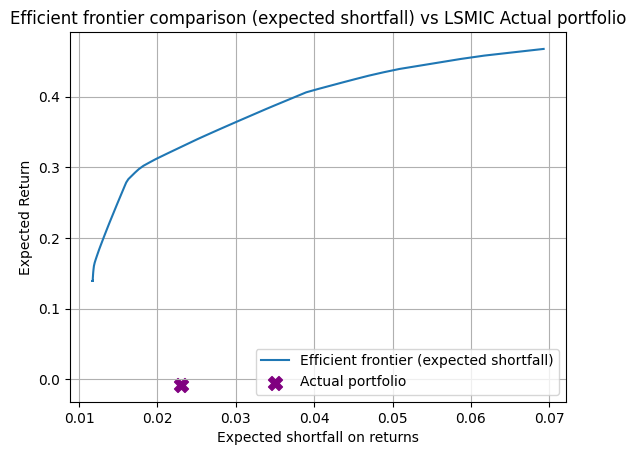

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns,EfficientCVaR

confidence_level = 0.99

mu = expected_returns.mean_historical_return(df)
historical_returns = expected_returns.returns_from_prices(df)
target_returns = np.linspace(0, mu.max()-0.01, 100)
ES_ExpShort = []
returns_ExpShort = []

for target_return in target_returns:
    es = EfficientCVaR(mu, historical_returns, weight_bounds=(0, 1), beta = confidence_level) # Ici le niveau de confiance (beta) est de base à 0.95
    es.efficient_return(target_return)
    portfolio_return,portfolio_ES= es.portfolio_performance()
    ES_ExpShort.append(portfolio_ES)
    returns_ExpShort.append(portfolio_return)

plt.plot(ES_ExpShort, returns_ExpShort, label = "Efficient frontier (expected shortfall)")


VaR = np.quantile(historical_returns.dot(actual_weights), (1-confidence_level))
ActualExpectedShortfall = -1*historical_returns.dot(actual_weights)[historical_returns.dot(actual_weights) <= VaR].mean()
plt.scatter(ActualExpectedShortfall, actual_return, marker="X", color="purple", s=100, label="Actual portfolio")

# Personnalisation du graphique
plt.title("Efficient frontier comparison (expected shortfall) vs LSMIC Actual portfolio")
plt.xlabel("Expected shortfall on returns")
plt.ylabel("Expected Return")
plt.legend()
plt.grid()
plt.show()


---

## Méthode sur la moyenne des drawdown at risk (équivalent à Expected Shortfall pour la VaR)

Ici, c'est une autre métrique, voir https://en.wikipedia.org/wiki/Drawdown_(economics)
voir aussi article, modélisation page 24 https://www.math.columbia.edu/~chekhlov/IJTheoreticalAppliedFinance.8.1.2005.pdf et page 26 c'est intéressant car preuve sur le fait que la frontière est une courbe concave.

Par rapport à la VaR, on regarde pour chaque temps $t$, le plus haut pic à gauche, et soustrait la valeur actuelle du cours, l'idée de garder le drawdown sous un certain seuil est de se protéger tant financièrement sur de lourdes pertes que psychologiquement, si l'on observe un énorme pic, nous serions tentés de retirer notre investissement pour en éviter d'encore plus lourdes. L'idée majeure c'est qu'il faut une augmentation de 100% pour récupérer son capital d'une perte de 50%.

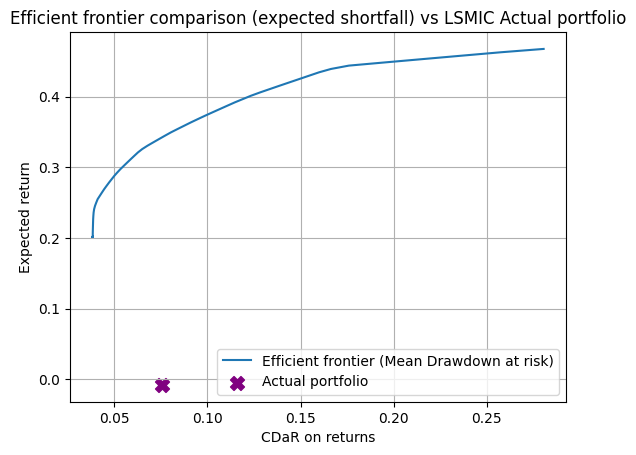

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns,EfficientCDaR

confidence_level = 0.99

mu = expected_returns.mean_historical_return(df)
historical_returns = expected_returns.returns_from_prices(df)
target_returns = np.linspace(0, mu.max()-0.01, 100)
CDaR_Drawdown = []
returns_Drawdown = []

for target_return in target_returns:
    es = EfficientCDaR(mu, historical_returns, weight_bounds=(0, 1), beta = confidence_level) # Ici le niveau de confiance (beta) est de base à 0.95
    es.efficient_return(target_return)
    portfolio_return,portfolio_CDaR= es.portfolio_performance()
    CDaR_Drawdown.append(portfolio_CDaR)
    returns_Drawdown.append(portfolio_return)

plt.plot(CDaR_Drawdown, returns_Drawdown, label = "Efficient frontier (Mean Drawdown at risk)")

portfolio_returns = historical_returns.dot(actual_weights)
cumulative_returns = (1 + portfolio_returns).cumprod()
peak = cumulative_returns.cummax()
drawdowns = (cumulative_returns - peak) / peak
VaR_drawdown = np.quantile(drawdowns, confidence_level)
ActualCDaR = -drawdowns[drawdowns <= VaR_drawdown].mean()

plt.scatter(ActualCDaR, actual_return, marker="X", color="purple", s=100, label="Actual portfolio")

# Personnalisation du graphique
plt.title("Efficient frontier comparison (expected shortfall) vs LSMIC Actual portfolio")
plt.xlabel("CDaR on returns")
plt.ylabel("Expected return")
plt.legend()
plt.grid()
plt.show()


---

La bibliothèque implémente aussi Black-Litterman mais c'est plus compliqué à exhiber un exemple concret, car la technique se base sur une attente particulière des investisseurs sur certaines actions.

Un exemple assez simple d'implémentation est dispo ici : 
https://github.com/thk3421-models/cardiel

Sinon voir 

https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html

https://fr.wikipedia.org/wiki/Mod%C3%A8le_de_Black-Litterman


---

En conclusion, le portefeuille du club n'est pas optimal, et je peux fournir des combinaisons de portefeuilles bien plus optimaux, respectant un budget donné comme par exemple : 

In [9]:
from pypfopt import EfficientFrontier, DiscreteAllocation, expected_returns

mu = expected_returns.mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf() 
ef = EfficientFrontier(mu, S,weight_bounds=(0, 1))

raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 

portfolio_value = 20000 # En se basant sur 20.000€
latest_prices = df.iloc[-1]  # prix récents à la fin de la période

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
allocation, leftover = da.lp_portfolio()

print("Répartition en parts entières :", allocation)
print("Ressources restantes :", leftover)


Répartition en parts entières : {'AAPL': 1, 'BX': 4, 'HEAL.AS': 3, 'HFG.DE': 2, 'IESE.AS': 28, 'INRG.MI': 3, 'MA': 8, 'MRK': 4, 'MSFT': 5, 'OGN': 1, 'SGLN.L': 2, 'TCEHY': 39, 'UMI.BR': 1, 'WLN.PA': 4}
Ressources restantes : 87.89299878259408


c:\Users\porti\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [10]:
mu = expected_returns.mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf() 
ef = EfficientFrontier(mu, S,weight_bounds=(0, 1))

raw_weights = ef.min_volatility()
cleaned_weights = ef.clean_weights() 

portfolio_value = 20000 # En se basant sur 20.000€
latest_prices = df.iloc[-1]  # prix récents à la fin de la période

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
allocation, leftover = da.lp_portfolio()

print("Répartition en parts entières :", allocation)
print("Ressources restantes:", leftover)

Répartition en parts entières : {'AAPL': 3, 'AED.BR': 5, 'HEAL.AS': 328, 'IESE.AS': 37, 'INRG.MI': 63, 'MA': 3, 'MRK': 24, 'MSFT': 2, 'NESN.SW': 33, 'SGLN.L': 1, 'TCEHY': 2, 'TEP.PA': 1, 'UMI.BR': 3}
Ressources restantes: 1552.064015761869


c:\Users\porti\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Et je peux aussi le faire en forçant des conditions telles que 40% ETF, 60% actions etc.